# Drug repurposing based on Network Proximity

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy

import networkx as nx

import os
import time

from collections import Counter

import random as random

import networkx as nx

from multiprocessing import Pool


In [2]:
# import the protein interactome dataset

df_ppi = pd.read_csv("ng_ppi.txt", sep="\t", header=None)


# rename the columns
df_ppi.rename(columns={0:"proteinA", 1:"proteinB"}, inplace=True)

# clean the dataset
df_ppi.drop_duplicates(inplace=True)
df_ppi.dropna(inplace=True)


# remove self loops

bool_list = (~(df_ppi["proteinA"]  == df_ppi["proteinB"])).to_list()
df_ppi = df_ppi.loc[bool_list, :]


# Quicker method to construct graph directly from pandas dataframe
# see documentation for better understanding
# https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html


G = nx.from_pandas_edgelist(df_ppi, source="proteinA", target = "proteinB")


# let's work only with Largest Connected Component
# Connected component?? 

# get all connected components
components = nx.connected_components(G)

# sort them in descending order by number of nodes in each broken connected components
lcclist = sorted(list(components), key = len, reverse=True)

# G1 represents the LCC and we will be working on only this from now onwards.
G1 = nx.subgraph(G, lcclist[0])

# calculate number of nodes, no. of edges
print("Number of nodes in network: ",G1.number_of_nodes())
print("Number of nodes in edges: ",G1.number_of_edges())



Number of nodes in network:  14710
Number of nodes in edges:  117269


In [3]:
# list of proteins in LCC of ng_ppi
nodes_ppi_lcc = list(G1.nodes())

In [7]:
# import drug target file
df_drug_target = pd.read_csv("match_uni_drug2.txt", sep="\t")



# remove all the uniprot_id's which are not present in main ppi lcc network 

bool_list = [ drug_node in nodes_ppi_lcc for drug_node in df_drug_target["UNIPROT"].to_list()  ]

df_drugs = df_drug_target.iloc[bool_list,:]

# clean the dataset
df_drugs = df_drugs.drop_duplicates()
df_drugs = df_drugs.dropna()


In [8]:
df_drugs

,UNIPROT,TARGET,DRUG
0,Q15172,T57291,D0W4IL
60,Q13542,T80011,D0FI9M
61,Q13542,T80011,D0W3RV
62,Q13542,T80011,D0QE7H
63,Q13542,T80011,D08HQI
...,...,...,...
42775,Q96AP4,T57050,D04MQF
42776,Q96AP4,T57050,D0EG8Y
42777,Q96AP4,T57050,D0EM8D
42778,Q96AP4,T57050,D0HQ8X


In [9]:
# obtaining dictionary of drug: targets

drug_id_list = df_drugs["DRUG"].unique().tolist()
#len(drug_id_list)

drug_targets = {}

for drug in drug_id_list:
    targets = df_drugs[df_drugs["DRUG"]==drug]["UNIPROT"].tolist()
    drug_targets[drug]=targets


In [10]:
# Number of drugs whose targets are present in LCC of ng_ppi
len(drug_targets)

25221

### Class Demonstration to convert Entrez_id to UniprotID

Entrez_id file: sarscov_EntrezID.txt

https://www.uniprot.org/uploadlists/

In [13]:
# obtaining list of disease genes
# This particular data is obtained from 
# https://github.com/Barabasi-Lab/COVID-19/blob/22c039ccbb892a0ce22ec828aefde77c6f674ef8/data/DatasetS1.csv

# After that the entrezID were converted to UniprotID(Swissprot) since ng_ppi proteins are given in uniprot format
df_disease = pd.read_csv('sarscov_disease_genes.csv')
df_disease

#genes affected by sars cov (above 300)

,SARS,EntrezID,Symbol,UniprotID
0,sars-cov2e,8546,AP3B1,Q8TAD8
1,sars-cov2e,23476,BRD4,Q9NYU1
2,sars-cov2e,6046,BRD2,Q13546
3,sars-cov2e,10283,CWC27,Q9NXH9
4,sars-cov2e,124245,ZC3H18,Q8WVC6
...,...,...,...,...
327,sars-cov2orf9c,617,BCS1L,P09601
328,sars-cov2orf9c,51103,NDUFAF1,Q9H3K2
329,sars-cov2orf9c,50999,TMED5,Q9BVL2
330,sars-cov2orf9c,4715,NDUFB9,Q8NBJ5


In [14]:
disease_genes = list(set(df_disease.iloc[:,3].tolist()))

# consider only the disease genes that are present in ng_ppi lcc and remove all the others disease gene targets
disease_genes = list(set(disease_genes).intersection(set(nodes_ppi_lcc)))

In [10]:
#print(nx.is_directed(G))
#print(nx.is_connected(G))

### The following code is obtained from https://github.com/Barabasi-Lab/COVID-19/tree/22c039ccbb892a0ce22ec828aefde77c6f674ef8 and the drug repurposing is based on Network Proximity. 
### For more details, please refer to the paper 

Morselli Gysi D, do Valle Í, Zitnik M, Ameli A, Gan X, Varol O, Ghiassian SD, Patten JJ, Davey RA, Loscalzo J, Barabási AL. Network medicine framework for identifying drug-repurposing opportunities for COVID-19. Proc Natl Acad Sci U S A. 2021 May 11;118(19):e2025581118. doi: 10.1073/pnas.2025581118. PMID: 33906951; PMCID: PMC8126852.

The **proximity** between a disease and a drug was evaluated using path lengths between drug targets and disease proteins. Given:
 - *S*, the set of disease proteins,
 - *T*, the set of drug targets and 
 - *d(s,t)*, the shortest path length between nodes s and t in the network, we define:
 
 
 **Closest distance:**
 
 $d_c(S,T) = \frac{1}{|T|} \cdot \sum_{t\in T}\  \ min_{s \in S}\   \ \cdot d(s,t)$
 

In [16]:
def calculate_closest_distance(network, nodes_from, nodes_to, lengths=None, weight="weight"):
    values_outer = []
    if lengths is None:
        for node_from in nodes_from:
            values = []
            for node_to in nodes_to:
                #val = network_utilities.get_shortest_path_length_between(network, node_from, node_to)
                
                ################# weights have been added   ##############################
                val = nx.shortest_path_length(network, node_from, node_to, weight=weight)
                
                values.append(val)
            d = min(values)
            #print d,
            values_outer.append(d)
    else:
        for node_from in nodes_from:
            values = []
            vals = lengths[node_from]
            for node_to in nodes_to:
                val = vals[node_to]
                values.append(val)
            d = min(values)
            values_outer.append(d)
    d = np.mean(values_outer)
    #print d
    return d


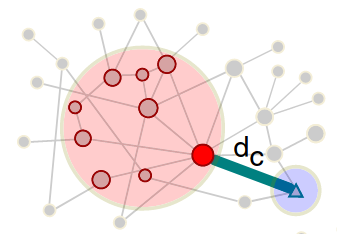
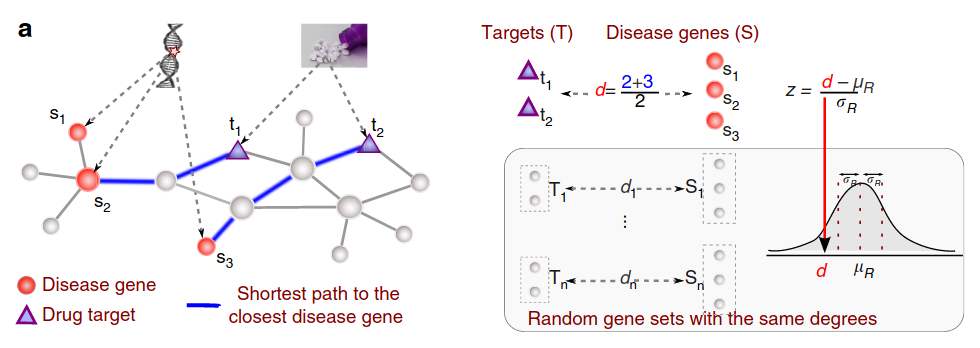





- Illustration of the closest distance $d_c$ of a drug *T* with targets $t_1$ and $t_2$ to the proteins $s_1$, $s_2$ and $s_3$ associated with disease *S*. 
- To measure the relative proximity $z_c$, we compare the distance $d_c$ between *T* and *S* to a reference distribution of distances observed if the drug targets and disease proteins are randomly chosen from the interactome. 
 - The reference distance distribution was generated by calculating the proximity between these two randomly selected groups, a procedure repeated 1,000 times. 
 
Network proximity: 

$z(S,T) = \frac{d(S,T) - \mu_{d(S,T)}}{\sigma_{d(S,T)}}$

$\mu_{d(S,T)}$ is mean and 

$\sigma_{d(S,T)}$ is std deviation of this reference distance distribution. They are used to convert observed distance $d_c(S,T)$ to normalized distance $z(S,T)$. 

- The obtained proximity $z_c$ quantifies whether a particular $d_c$ is smaller than expected by chance. 

- To account for the heterogeneous degree distribution of the interactome and differences in the number of drug targets and disease proteins, we preserve the number and degrees of the randomized targets and disease proteins.


$z < 0$ is considered to be proximal drug for the disease according to network based approach. The drugs whose z-value less than 0 are to be considered for further investigation. 


**Reference**: Guney E, Menche J, Vidal M, Barábasi AL. Network-based in silico drug efficacy screening. Nat Commun. 2016 Feb 1;7:10331. doi: 10.1038/ncomms10331. PMID: 26831545; PMCID: PMC4740350.

In [17]:
# Reference distribution

# due to the scale-free nature of the human interactome, there are few nodes with high degrees
#  To avoid repeatedly choosing the same (high degree) nodes during the degree-preserving random selection, 
# we use a binning approach in which nodes within a certain degree interval were grouped together such that there
# were at least 100 nodes in the bin. 

def get_degree_binning(g, bin_size, lengths=None,weight="weight"):
    degree_to_nodes = {}
    for node, degree in g.degree(weight=weight): #.items(): # iterator in networkx 2.0
        if lengths is not None and node not in lengths:
            continue
        degree_to_nodes.setdefault(degree, []).append(node)
        #print(degree_to_nodes)
    values = sorted(degree_to_nodes.keys()) # degree
    bins = []
    i = 0
    while i < len(values):
        low = values[i]
        val = degree_to_nodes[values[i]]
        while len(val) < bin_size:
            i += 1
            if i == len(values):
                break
            val.extend(degree_to_nodes[values[i]])
        if i == len(values):
            i -= 1
        high = values[i]
        i += 1
        #print i, low, high, len(val)
        if len(val) < bin_size:
            low_, high_, val_ = bins[-1]
            bins[-1] = (low_, high, val_ + val)
        else:
            bins.append((low, high, val))
    return bins

Accordingly, each bin $B_{i,j}$ was defined as:
$B_{i,j} = \{u\in V | i \leq k_u < j \}$ containing the nodes with degrees $i$ to minimum possible degrees $j$ such that $|B_{i,j}|\geq100$.

In [18]:
#https://github.com/Barabasi-Lab/COVID-19/blob/22c039ccbb892a0ce22ec828aefde77c6f674ef8/utils/guney_code/network_utilities.py#L1025
def get_random_nodes(nodes, network, bins=None, n_random=1000, min_bin_size=100, degree_aware=True, seed=None,weight="weight"):
    if bins is None:
        # Get degree bins of the network
        bins = get_degree_binning(network, min_bin_size, weight=weight)
    nodes_random = pick_random_nodes_matching_selected(network, bins, nodes, n_random, degree_aware, seed=seed, weight=weight)
    return nodes_random



def pick_random_nodes_matching_selected(network, bins, nodes_selected, n_random, degree_aware=True, connected=False, seed=None, weight="weight"):
    """
    Use get_degree_binning to get bins
    """
    
    if seed is not None:
        random.seed(seed)
    values = []
    nodes = network.nodes()
    for i in range(n_random):
        if degree_aware:
            if connected:
                raise ValueError("Not implemented!")
            nodes_random = set()
            
            node_to_equivalent_nodes = get_degree_equivalents(nodes_selected, bins, network, weight=weight)
            
            for node, equivalent_nodes in node_to_equivalent_nodes.items():
                    #nodes_random.append(random.choice(equivalent_nodes))
                chosen = random.choice(equivalent_nodes)
                for k in range(20): # Try to find a distinct node (at most 20 times)
                    if chosen in nodes_random:
                        chosen = random.choice(equivalent_nodes)
                nodes_random.add(chosen)
            nodes_random = list(nodes_random)
        else:
            if connected:
                nodes_random = [ random.choice(nodes) ]
                k = 1
                while True:
                    if k == len(nodes_selected):
                        break
                    node_random = random.choice(nodes_random)
                    node_selected = random.choice(network.neighbors(node_random))
                    if node_selected in nodes_random:
                        continue
                    nodes_random.append(node_selected)
                    k += 1
            else:
                nodes_random = random.sample(nodes, len(nodes_selected))
        values.append(nodes_random)
    return values



def get_degree_equivalents(seeds, bins, g, weight="weight"):
    seed_to_nodes = {}
    for seed in seeds:
        d = g.degree(seed, weight=weight)
        for l, h, nodes in bins:
            if l <= d and h >= d:
                mod_nodes = list(nodes)
                mod_nodes.remove(seed) # we remove the seed node so that it doesn't get represented
                seed_to_nodes[seed] = mod_nodes
                break
    return seed_to_nodes


In [27]:
# https://github.com/Barabasi-Lab/COVID-19/blob/22c039ccbb892a0ce22ec828aefde77c6f674ef8/utils/guney_code/wrappers.py#L627

# nodes_from -> drug targets of a single drug
# nodes_to -> all disease targets 
def calculate_proximity(network, nodes_from, nodes_to,nodes_from_random=None, nodes_to_random=None, bins=None, n_random=1000, min_bin_size=100, seed=452456, lengths=None, weight="weight"):
    """
    Calculate proximity from nodes_from to nodes_to
    If degree binning or random nodes are not given, they are generated
    lengths: precalculated shortest path length dictionary
    """
    #distance = "closest"
    #lengths = network_utilities.get_shortest_path_lengths(network, "../data/toy.sif.pcl")
    #d = network_utilities.get_separation(network, lengths, nodes_from, nodes_to, distance, parameters = {})
    
    nodes_network = set(network.nodes())
    nodes_from = set(nodes_from) & nodes_network
    nodes_to = set(nodes_to) & nodes_network
    
    
    if len(nodes_from) == 0 or len(nodes_to) == 0:
        return None # At least one of the node group not in network
    
    ########################### weights have been added   ##############################
    d = calculate_closest_distance(network, nodes_from, nodes_to, lengths=lengths,weight=weight)
    
    if bins is None and (nodes_from_random is None or nodes_to_random is None):
        #print("weight, lengths, min_bin_size ",weight, lengths, min_bin_size)
        
        bins = get_degree_binning(network, min_bin_size, lengths=lengths, weight=weight)
        # if lengths is given, it will only use those nodes
    
    if nodes_from_random is None:
        nodes_from_random = get_random_nodes(nodes_from, network, bins = bins, n_random = n_random,\
                                             min_bin_size = min_bin_size, seed = seed, weight=weight)
    
    if nodes_to_random is None:
        nodes_to_random = get_random_nodes(nodes_to, network, bins = bins, n_random = n_random, \
                                           min_bin_size = min_bin_size, seed = seed, weight=weight)
    
    random_values_list = zip(nodes_from_random, nodes_to_random)
    values = np.empty(len(nodes_from_random)) #n_random
    
    
    # calculate closest distance is taking a lot of time...........
    for i, values_random in enumerate(random_values_list):
        #print(values_random)
        nodes_from, nodes_to = values_random
        #values[i] = network_utilities.get_separation(network, lengths, nodes_from, nodes_to, distance, parameters = {})
        values[i] = calculate_closest_distance(network, nodes_from, nodes_to, lengths=lengths,weight=weight)
    #pval = float(sum(values <= d)) / len(values) # needs high number of n_random
    
    m, s = np.mean(values), np.std(values)
    if s == 0:
        z = 0.0
    else:
        z = (d - m) / s
    return d, z, (m, s) #(z, pval)






In [24]:
# https://github.com/Barabasi-Lab/COVID-19/blob/22c039ccbb892a0ce22ec828aefde77c6f674ef8/04_DR_Proximity.py#L73

# computes d, z , m, s of a single drug to all disease targets
def single_proximity( sample ):
    # drug_key = for a single specific drug
    # drug_targets: dictionary of drugs and its corresponding targets
    # G: networkx graph
    
    # disease genes: list of disease targets
    # nsims: no. of random simulations for computing Z score factor
    # seed: random number generation seed
    
    
    # consider only the largest connected component
    drug_key = sample[0]
    drug_targets = sample[1]
    disease_genes = sample[2]
    G1 = sample[3]
    nsims=sample[4]
    #weight = sample[5]
    
    # Since the network doesn't have edge weights, it is kept as "None". 
    # In case there is presence of edge weights in your network, please change it to.....
    # weight = "weight"
    weight=None
    
    min_bin_size=60 #100 
    seed=12345#None  
    
    
    # collect the targets of a specific drug which is also present in lcc
    nodes_from =  set(drug_targets[drug_key]) & set(G1.nodes())
    # collect the targets of disease which are also present in lcc 
    nodes_to =  set(disease_genes) & set(G1.nodes())
    
    
    if len(nodes_from) == 0 | len(nodes_to) == 0: # if no applicable target(either drug or disease), stop
        return #(drug_key, np.nan, np.nan, np.nan, np.nan )
    
    # computing proximity. Please set the parameters to proper values.
    d, z, (mean, sd) = calculate_proximity(G1, nodes_from, nodes_to, n_random=nsims, 
                                           min_bin_size = min_bin_size, seed=seed, weight=weight)
    return (drug_key, np.round(d,3), np.round(z,3), np.round(mean,3), np.round(sd,3) )
    
    

In [29]:
# I have considered only first 100 drugs for the purpose of demonstration. 
# Since the number of drugs are ~ 25000, it takes quite some time.

drug_keys = list(drug_targets.keys())[:100]


In [30]:

# create sameples list for parallel processing.
samples = []

# 
nsims=10 #sample[4]
#weight = None

for i in range(len(drug_keys)):
    samples.append([drug_keys[i], drug_targets, disease_genes, G1, nsims])#, weight])

In [31]:
# set up parallel computing
ncpus=4

import time
import datetime
start_time = time.time()

s = time.time()

p = Pool(ncpus)
res = p.map(single_proximity, samples)

# The results of network proximity are stored in "proximity.txt".
# drug for which z_score < 0 is a valid drug
with open('proximity.txt', 'w') as f:
    f.write("drug" +'\t'+ "d" +'\t'+ "z_score" +'\t' + "mean_d_random" +'\t'+ "sd_random" +'\n')

    for result in res:
        drug_key, d, z, mean, sd = result[0], result[1], result[2], result[3], result[4]
        f.write(drug_key +'\t'+ str(np.round(d,5)) +'\t'+ str(np.round(z,5)) +'\t' + str(np.round(mean,5)) +'\t'+ str(np.round(sd,5))+'\n')

p.close()
p.join()

f.close()

e = time.time() - s

print ('Finished in %f min'%(e/60))

#now = datetime.datetime.now()

#print ("Current time: ")
#print (now.strftime("%H:%M:%S"))

Finished in 2.872594 min


If curious on working on Complemetary exposure for drug-drug combination for drug repurposing as given in the paper:


Cheng F, Kovács IA, Barabási AL. Network-based prediction of drug combinations. Nat Commun. 2019 Mar 13;10(1):1197. doi: 10.1038/s41467-019-09186-x. Erratum in: Nat Commun. 2019 Apr 15;10(1):1806. PMID: 30867426; PMCID: PMC6416394

Please refer to the code here for getting ideas:
https://github.com/Barabasi-Lab/COVID-19/blob/22c039ccbb892a0ce22ec828aefde77c6f674ef8/utils/separation.py